# OCR

> Functions for OCR.

In [ ]:
#| default_exp ocr

In [ ]:
#| hide

from nbdev.showdoc import *
from fastcore.test import *

%nbdev_skip_test
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

UsageError: Line magic function `%nbdev_skip_test` not found.


In [ ]:
#| export

from dreamai.core import *
from dreamai.vision import *
from dreamai_resume.imports import *

In [ ]:
#| export

def split_words(t):
    if t.count('0') <= 1:
        t = t.replace('0', 'O')
    return " ".join(wordninja.split(t.lower().replace(" ",'')))

def all_cases(text):
    "Return all cases of a string."
    return [text.upper(), text.lower(), text.capitalize(), text.title()]
def remove_ns(l):
    return flatten_list([t.split('\n') for t in l])

def cleanup_text(text, spell_checker=None):
    txt = "".join([c if ord(c) < 128 else "" for c in text]).strip()
    if spell_checker is not None:
        txt2 = []
        for t in txt.split():
            # print(sc.candidates(t))
            txt2.append(spell_checker.correction(t))
        return ' '.join(txt2)
    return txt

def align_images(image, template, maxFeatures=500, keepPercent=0.2, debug=False):
	"Align image based on template"
	imageGray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
	templateGray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
	orb = cv2.ORB_create(maxFeatures)
	(kpsA, descsA) = orb.detectAndCompute(imageGray, None)
	(kpsB, descsB) = orb.detectAndCompute(templateGray, None)
	method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
	matcher = cv2.DescriptorMatcher_create(method)
	matches = matcher.match(descsA, descsB, None)
	matches = sorted(matches, key=lambda x:x.distance)
	keep = int(len(matches) * keepPercent)
	matches = matches[:keep]
	if debug:
		matchedVis = cv2.drawMatches(image, kpsA, template, kpsB,
			matches, None)
		matchedVis = imutils.resize(matchedVis, width=1000)
		plt_show(matchedVis)
	ptsA = np.zeros((len(matches), 2), dtype="float")
	ptsB = np.zeros((len(matches), 2), dtype="float")
	for (i, m) in enumerate(matches):
		ptsA[i] = kpsA[m.queryIdx].pt
		ptsB[i] = kpsB[m.trainIdx].pt
	(H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)
	(h, w) = template.shape[:2]
	aligned = cv2.warpPerspective(image, H, (w, h))

	return aligned

def bbox_in_config(bbox, config):
    x1,y1 = bbox[0]
    x2,y2 = bbox[2]
    cx1,cy1 = config[0]
    cx2,cy2 = config[1]
    return x1>=cx1 and x2<=cx2 and y1>=cy1 and y2<=cy2

def hand_ocr(img, model, processor):
    "OCR if the text is hand written."
    if model is None or processor is None:
        return ''
    try:
        pixel_values = processor(images=img, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values.to(model.device))
        return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    except:
        return ''
    
def pdf_to_imgs(file_path,
                stack_pages=False, # Stack all pages into one image.
                **kwargs):
    "Convert a pdf at `file_path` to image(s)."
    file_path = str(file_path)
    is_pdf = False    
    if path_suffix(file_path) == '.pdf':
        is_pdf = True
        imgs = convert_from_path(file_path)
        if stack_pages:
            imgs = [np.concatenate(imgs, axis=0)]
    else:
        imgs = [rgb_read(file_path)]
    return imgs, is_pdf

def dai_ocr(reader, file_path,
            template_path='', # For aligning the image.
            h_thresh=2048, # Resize image if height is lesser than this.
            batch_size=8, workers=4, width_ths=0.6, height_ths=0.6, x_ths=1., y_ths=0.5,
            low_text=0.6, link_threshold=0.65, add_margin=0.2, contrast_ths=0.1, show=False,
            config='', # JSON file with bounding boxes of sections and a list of sections to ignore.
            paragraph=False, hand_written=False, hand_processor=None, hand_model=None, spell_checker=None,
            bbox_thickness=2, bbox_color='green', stack_pages=False):
    
    imgs,is_pdf = pdf_to_imgs(file_path=file_path, stack_pages=stack_pages)
    
    ocr_dict = {}
    all_text = []
    for i,img in enumerate(imgs):
        img = np.array(img)
        if len(template_path) > 0:
            template = rgb_read(template_path)
            ih,_ = get_hw(img)
            th,_ = get_hw(template)
            if ih < th:
                img = imutils.resize(img, height=th)
            aligned = align_images(img, template)
            overlay = template.copy()
            img = aligned.copy()
            cv2.addWeighted(overlay, 0.5, img, 0.5, 0, img)
        h,w = get_hw(img)
        h_diff = 0
        w_diff = 0
        if h < h_thresh:
            img = imutils.resize(img, height=h_thresh)
            h2,w2 = get_hw(img)
            h_diff = h2-h
            w_diff = w2-w
        if hand_written:
            width_ths += 0.25
            height_ths += 0.35
        result = reader.readtext(img, batch_size=batch_size, workers=workers, width_ths=width_ths, height_ths=height_ths, low_text=low_text,
                                 x_ths=x_ths, y_ths=y_ths, link_threshold=link_threshold, add_margin=add_margin, paragraph=paragraph,
                                 contrast_ths=contrast_ths)
        if paragraph:
            for ir in range(len(result)):
                result[ir].append(0.95)
        ocr_dict[f'PAGE_{i+1}'] = {'Result':[]}
        boxes, texts, confs = [], [], []
        for bbox,text,conf in result:
            tl,tr,br,bl = bbox
            tl = int(tl[0]), int(tl[1])
            tr = int(tr[0]), int(tr[1])
            br = int(br[0]), int(br[1])
            bl = int(bl[0]), int(bl[1])
            if hand_written:
                text = hand_ocr(img[tl[1]:br[1], tl[0]:br[0]], hand_model, hand_processor)
            text = cleanup_text(text, spell_checker=spell_checker)
            boxes.append([[int(y) for y in x] for x in bbox])
            texts.append(text)
            confs.append(conf)
            cv2.rectangle(img, tl, br, color_to_rgb(bbox_color), bbox_thickness)
            cv2.putText(img, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        result = zip(boxes, texts, confs)
        torch.cuda.empty_cache()
        if len(config) == 0 or is_pdf:
            ocr_dict[f'PAGE_{i+1}'] = {'Result':[{'bbox': [[int(y) for y in x] for x in bb], 'text': cleanup_text(text, spell_checker=spell_checker),
                                                 'confidence': float(f'{conf:.2f}')} for bb,text,conf in result]}
        else:
            config = json.load(open(config))
            ocr_dict[f'PAGE_{i+1}'] = {}
            for k,v in config.items():
                cbox = v['bbox']
                ignore_list = v.get('ignore_list', [])
                ignore_list = flatten_list([all_cases(ig) for ig in ignore_list])
                cbox = [[x[0]+w_diff, x[1]+h_diff] for x in cbox]
                ocr_dict[f'PAGE_{i+1}'][k] = []
                print(f'\nIGNORE LIST: {ignore_list}')
                for bb,text,conf in result:
                    # if cleanup_text(text, spell_checker=spell_checker).lower() == 'rosebrock':
                        # print(f'\nBB: {bb[0]},{bb[2]}    CONFIG: {v}')
                    # text = cleanup_text(text, spell_checker=spell_checker)
                    for ig in ignore_list:
                        text = text.replace(ig,"").replace("  "," ").strip()
                    if bbox_in_config(bb, cbox) and len(text) > 0:
                        ocr_dict[f'PAGE_{i+1}'][k].append({'bbox': [[int(y) for y in x] for x in [bb[0],bb[2]]],
                                            'text': text, 'confidence': float(f'{conf:.2f}')})
        if show:
            plt_show(img)
        all_text += texts
    return ocr_dict, all_text

## Some usage examples:

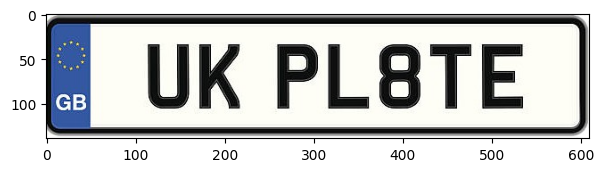

In [ ]:
img = rgb_read('../imgs/n_plate.jpg')
plt_show(img)

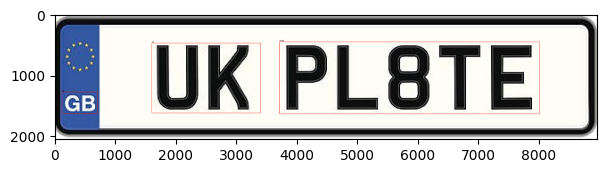

In [ ]:
reader = easyocr.Reader(['en'])
ocr_dict, all_text = dai_ocr(reader, '../imgs/n_plate.jpg', show=True, add_margin=0.3, bbox_thickness=4, bbox_color='red')

In [ ]:
all_text

['PLBTE', 'UK', 'GB']

In [ ]:
ocr_dict # Has the bounding box coordinates and confidence of each text detected.

{'PAGE_1': {'Result': [{'bbox': [[3710, 443],
     [8009, 443],
     [8009, 1630],
     [3710, 1630]],
    'text': 'PLBTE',
    'confidence': 0.81},
   {'bbox': [[1599, 463], [3398, 463], [3398, 1617], [1599, 1617]],
    'text': 'UK',
    'confidence': 0.95},
   {'bbox': [[115, 1271], [697, 1271], [697, 1630], [115, 1630]],
    'text': 'GB',
    'confidence': 0.99}]}}

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()